In [69]:
# =====================================
# 📦 IMPORTS & INITIAL SETUP
# =====================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models

# Set seed for reproducibility
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [28]:
# =====================================
# 📂 LOAD DATA
# =====================================
DATA_PATH = "data"
SUBMISSION_PATH = "submissions"

train = pd.read_csv(os.path.join(DATA_PATH, "Train.csv"))
test = pd.read_csv(os.path.join(DATA_PATH, "Test.csv"))
weather = pd.read_csv(os.path.join(DATA_PATH, "Accra_weather.csv"), index_col=0)

print("TRAIN")
print(train.head())
print("TEST")
print(test.head())
print("WEATHER")
print(weather.head())

TRAIN
         trip_id  destination_lat  destination_lon lcl_start_transporting_dt  \
0  ID_S3BD1V9G53         5.630927        -0.169211                2024-05-05   
1  ID_ZJM7LMN65Q         5.645044        -0.156482                2024-05-21   
2  ID_SZ3BP6V01V         5.711156        -0.141063                2024-05-05   
3  ID_5IPHXDCMKF         5.677497        -0.183350                2024-05-26   
4  ID_BYZEJ0B5RA         5.601700        -0.173589                2024-05-30   

  lcl_start_transporting_dttm  origin_lat  origin_lon  str_distance_km  \
0         2024-05-05 09:56:32    5.630979   -0.164760            0.529   
1         2024-05-21 10:53:32    5.686892   -0.118931            6.230   
2         2024-05-05 21:21:21    5.706008   -0.164999            2.705   
3         2024-05-26 21:23:33    5.665943   -0.182602            1.236   
4         2024-05-30 14:02:13    5.565401   -0.160919            4.312   

   transporting_distance_fact_km  Target  
0                        

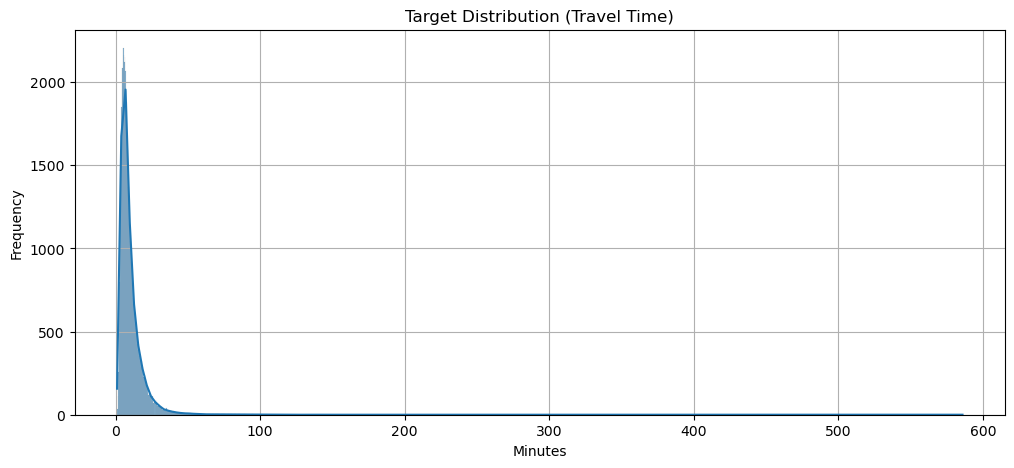

Train shape: (57596, 10)
Test shape: (24684, 9)
Target skew: 10.334243815626118


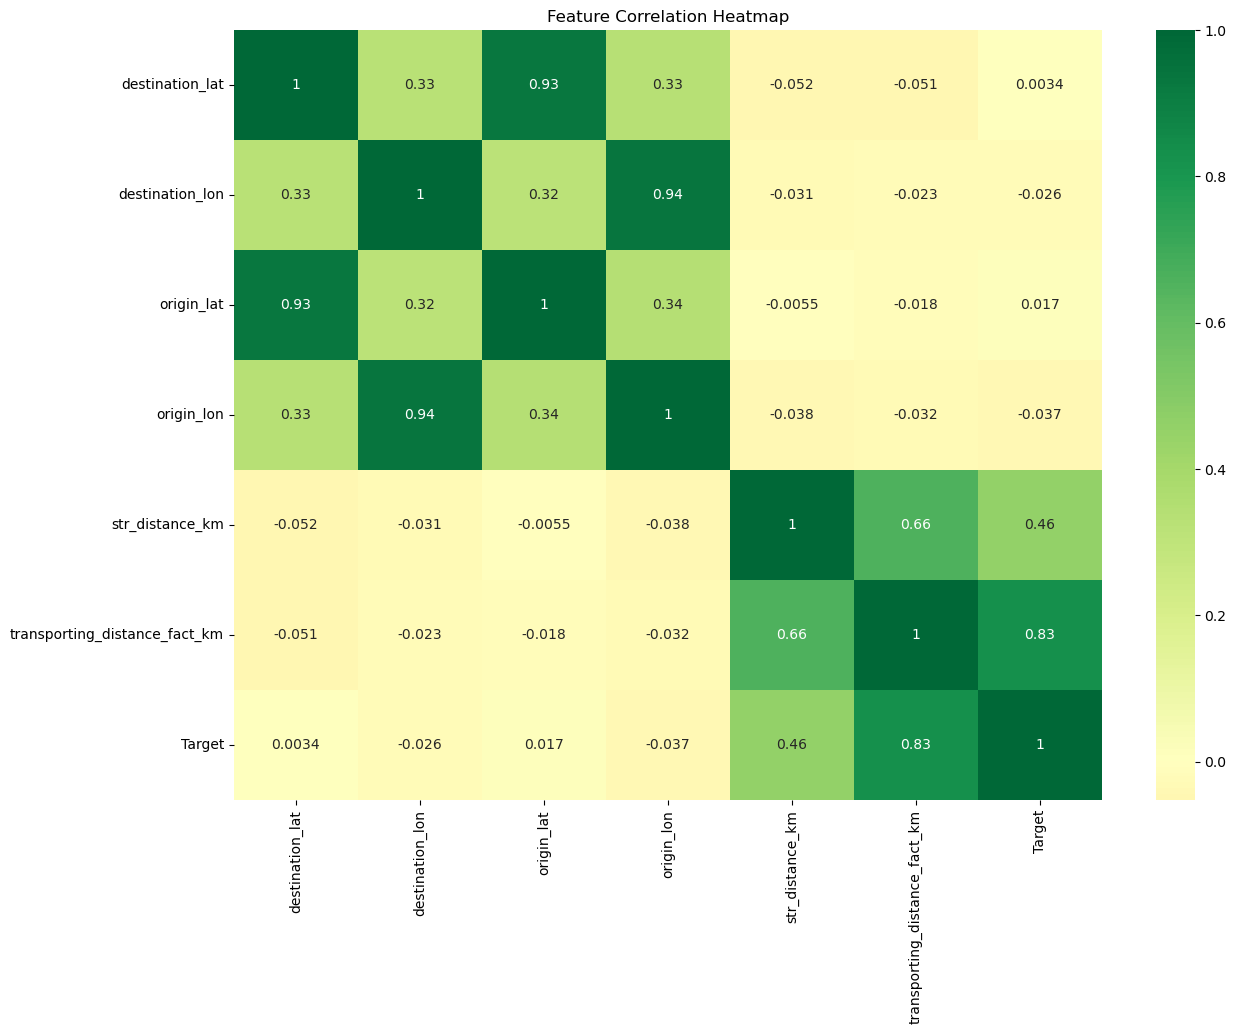

In [3]:
# =====================================
# 📊 EXPLORATORY DATA ANALYSIS (EDA)
# =====================================
# --- Visualize Target Distribution
plt.figure(figsize=(12, 5))
sns.histplot(train['Target'], kde=True)
plt.title('Target Distribution (Travel Time)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- Basic Stats
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Target skew:", train['Target'].skew())

# --- Correlation Heatmap
numerics = train.select_dtypes(include='number')
plt.figure(figsize=(14, 10))
sns.heatmap(numerics.corr(), annot=True, cmap='RdYlGn', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [29]:
# =====================================
# 🧠 FEATURE ENGINEERING FUNCTION FOR TRIPS
# =====================================
def create_trip_features(df):
    df = df.copy()

    # Parse datetime columns
    df['lcl_start_transporting_dttm'] = pd.to_datetime(df['lcl_start_transporting_dttm'])
    df['hour'] = df['lcl_start_transporting_dttm'].dt.hour
    df['day'] = df['lcl_start_transporting_dttm'].dt.day
    df['month'] = df['lcl_start_transporting_dttm'].dt.month
    df['dayofweek'] = df['lcl_start_transporting_dttm'].dt.weekday
    df['weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Rush hour
    df['rush_hour'] = ((df['hour'].between(7, 9)) | (df['hour'].between(17, 19))).astype(int)

    # Sine/Cosine transforms for hour of day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Distance ratio (handle division by zero)
    df['distance_ratio'] = np.where(df['str_distance_km'] > 0,
                                    df['transporting_distance_fact_km'] / df['str_distance_km'],
                                    1.0)
    df['distance_ratio'] = np.clip(df['distance_ratio'], 0, 10)

    # Distance difference
    df['distance_diff'] = df['transporting_distance_fact_km'] - df['str_distance_km']

    # Distance bucket
    df['distance_bucket'] = pd.cut(df['transporting_distance_fact_km'], bins=[0, 2, 5, 10, 20, 50], labels=False)

    # Time of day bucket
    df['time_bucket'] = pd.cut(df['hour'], bins=[-1, 6, 12, 17, 21, 24], labels=[0, 1, 2, 3, 4])

    # Add day_hour for merging with weather
    df['day_hour'] = df['day'].astype(str) + '_' + df['hour'].astype(str)

    return df

In [30]:
# =====================================
# 🌦️ FEATURE ENGINEERING FOR WEATHER DATA
# =====================================
def create_weather_features(df):
    df = df.copy()
    df['lcl_datetime'] = pd.to_datetime(df['lcl_datetime'])
    df['lcl_datetime_hour'] = df['lcl_datetime'].dt.hour
    df['lcl_datetime_day'] = df['lcl_datetime'].dt.day
    df['lcl_datetime_month'] = df['lcl_datetime'].dt.month
    df['day_hour'] = df['lcl_datetime_day'].astype(str) + '_' + df['lcl_datetime_hour'].astype(str)

    # One-hot encode precipitation type
    precip_dummies = pd.get_dummies(df['precipitation_type'], prefix='precip')
    df = pd.concat([df, precip_dummies], axis=1)

    # Rolling window features (3-hour)
    df = df.sort_values(by='lcl_datetime')
    df['precip_mm_roll3'] = df['prev_hour_precipitation_mm'].rolling(window=3, min_periods=1).mean()
    df['temp_C_roll3'] = df['temperature_C'].rolling(window=3, min_periods=1).mean()

    # Lag features
    df['precip_mm_lag1'] = df['prev_hour_precipitation_mm'].shift(1)
    df['temp_C_lag1'] = df['temperature_C'].shift(1)

    # Difference features
    df['precip_mm_diff'] = df['prev_hour_precipitation_mm'] - df['precip_mm_lag1']
    df['temp_C_diff'] = df['temperature_C'] - df['temp_C_lag1']

    df.fillna(0, inplace=True)
    return df

In [31]:
# Apply to datasets
train = create_trip_features(train)
test = create_trip_features(test)
weather = create_weather_features(weather)

# Merge weather data
train = train.merge(weather, on='day_hour', how='left', suffixes=('', '_weather'))
test = test.merge(weather, on='day_hour', how='left', suffixes=('', '_weather'))

In [33]:
# weather.head()

In [61]:
# =====================================
# ✅ SELECT FINAL FEATURES
# =====================================
features = [
    'str_distance_km', 'transporting_distance_fact_km', 'distance_ratio', 'distance_diff', 'distance_bucket',
    'origin_lat', 'origin_lon', 'destination_lat', 'destination_lon',
    'hour', 'day', 'dayofweek', 'rush_hour', 'weekend', 'time_bucket',
    'hour_sin', 'hour_cos',
    'temperature_C', 'prev_hour_precipitation_mm', 'precip_mm_roll3', 'temp_C_roll3',
    'precip_mm_lag1', 'temp_C_lag1', 'precip_mm_diff', 'temp_C_diff'
    # 'precip_Rain', 'precip_No precipitation'
]

# Add encoded precipitation columns
# features.extend([col for col in train.columns if col.startswith('precip_')])

X = train[features].fillna(0)
y = train['Target']
X_test_final = test[features].fillna(0)

In [62]:
# =====================================
# 📈 SCALE DATA
# =====================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)


In [63]:
# =====================================
# 🔪 SPLIT TRAIN/VALIDATION
# =====================================
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

In [70]:
# =====================================
# 🔁 CROSS VALIDATION & HYPERPARAMETER TUNING
# =====================================
def build_tf_model(input_dim, hp):
    model = models.Sequential()
    model.add(layers.Dense(hp['units1'], input_shape=(input_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(hp['dropout1']))

    model.add(layers.Dense(hp['units2']))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(hp['dropout2']))

    model.add(layers.Dense(hp['units3']))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp['lr']),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

# Define parameter space
param_grid = [
    {'units1': 256, 'units2': 128, 'units3': 64, 'dropout1': 0.3, 'dropout2': 0.3, 'lr': 0.001},
    {'units1': 512, 'units2': 256, 'units3': 128, 'dropout1': 0.4, 'dropout2': 0.3, 'lr': 0.0005},
    {'units1': 256, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.001}
]

best_rmse = float('inf')
best_model = None
best_params = None

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for hp in param_grid:
    fold_rmses = []
    for train_idx, val_idx in kf.split(X_scaled):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = build_tf_model(X_train.shape[1], hp)

        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
        ]

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=256,
            callbacks=callbacks,
            verbose=0
        )

        val_preds = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        fold_rmses.append(rmse)

    avg_rmse = np.mean(fold_rmses)
    print(f"Params: {hp} --> CV RMSE: {avg_rmse:.4f}")
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model = model
        best_params = hp

print(f"\nBest Params: {best_params} --> Best RMSE: {best_rmse:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
Params: {'units1': 256, 'units2': 128, 'units3': 64, 'dropout1': 0.3, 'dropout2': 0.3, 'lr': 0.001} --> CV RMSE: 4.4150


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
Params: {'units1': 512, 'units2': 256, 'units3': 128, 'dropout1': 0.4, 'dropout2': 0.3, 'lr': 0.0005} --> CV RMSE: 4.3905


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
Params: {'units1': 256, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.001} --> CV RMSE: 4.3880

Best Params: {'units1': 256, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.001} --> Best RMSE: 4.3880


In [57]:
# from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor()
# model.fit(
#     X_train, y_train)

In [66]:
# =====================================
# 🏋️‍♂️ TRAIN MODEL
# =====================================
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 90.3707 - mae: 6.3910 - val_loss: 30.2004 - val_mae: 3.2493 - learning_rate: 0.0010
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.2041 - mae: 3.3294 - val_loss: 18.9810 - val_mae: 2.4629 - learning_rate: 0.0010
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.9624 - mae: 3.2031 - val_loss: 17.5907 - val_mae: 2.3909 - learning_rate: 0.0010
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.2509 - mae: 3.1276 - val_loss: 17.1356 - val_mae: 2.3647 - learning_rate: 0.0010
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.0604 - mae: 3.0698 - val_loss: 17.1194 - val_mae: 2.3490 - learning_rate: 0.0010
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.0250 - mae: 3.0502 - val_loss: 17.3336 - val_mae: 2.3465 - learning_rate: 0.0010
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.6927 - mae: 2.9886 - val_loss: 17.4122 - val_mae: 2.3462 - learnin

In [71]:
# =====================================
# 📉 EVALUATION
# =====================================
val_preds = model.predict(X_val).flatten()
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Validation RMSE: {rmse:.4f}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
Validation RMSE: 3.9012


In [72]:
# =====================================
# 📤 PREDICT & SUBMIT
# =====================================
test_preds = model.predict(X_test_scaled).flatten()

submission = pd.DataFrame({
    'trip_id': test['trip_id'],
    'Target': np.clip(test_preds, 1, None)  # prevent negative predictions
})

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"NNN__{timestamp}.csv"
submission.to_csv(os.path.join(SUBMISSION_PATH, filename), index=False)
print(f"Submission saved as: {filename}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
Submission saved as: NNN__20250705_150918.csv
